In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
# instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# board_image = cv2.imread("datasets/calib/right_1.jpg", 0)
# imshow(
#     board_image,
#     title="checkerboard 6x9"
# )

In [3]:
# checkerboard = (6, 9)
# import calib
# found, corners = calib.detect_board(checkerboard, board_image)

In [4]:
# show_board = cv2.cvtColor(board_image, cv2.COLOR_GRAY2BGR)

# # dibujo los corners usando la función drawChessboardCorners de OpenCV
# show_board_cv = cv2.drawChessboardCorners(
#     show_board.copy(),
#     checkerboard,
#     corners,
#     found
# )

# # dibujo los corners usando la función drawChessboardCorners de OpenCV
# show_board_mine = calib.draw_checkerboard(
#     show_board.copy(),
#     checkerboard,
#     corners,
#     found
# )

# show_images([
#     #board_image,
#     show_board_cv,
#     show_board_mine
# ], ["drawChessboardCorners (CV)", "draw_checkerboard (Custom)"])

In [5]:
# Cargar archivos
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)
    
with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

# Explorar qué contienen
print("Calibración keys:", calib.keys())
print("Maps keys:", maps.keys())
# Típicamente: K1, K2, D1, D2, R, T, Q, P1, P2, etc.


Calibración keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


In [6]:
def rectify_stereo_pair(left_img, right_img, stereo_maps):
    """Rectifica un par estéreo usando mapas pre-computados"""
    left_img  = cv2.imread(left_img)
    right_img = cv2.imread(right_img)
    left_rect = cv2.remap(left_img, 
                         stereo_maps['left_map_x'], 
                         stereo_maps['left_map_y'], 
                         cv2.INTER_LINEAR)
    
    right_rect = cv2.remap(right_img,
                          stereo_maps['right_map_x'],
                          stereo_maps['right_map_y'],
                          cv2.INTER_LINEAR)
    
    return left_rect, right_rect

in_dir  = Path("data/stereo_bus_charuco/captures")
out_dir = Path("data/stereo_bus_charuco/rectified")
out_dir.mkdir(exist_ok=True)

# Índices a procesar (14..37). Si falta alguno, el loop lo saltea.
indices = list(range(14, 38))

procesados = 0
faltantes = []

for i in indices:
    lp = in_dir / f"left_{i}.jpg"
    rp = in_dir / f"right_{i}.jpg"
    if not lp.exists() or not rp.exists():
        faltantes.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(lp), str(rp), maps)

    # Guardar
    cv2.imwrite(str(out_dir / f"rect_left_{i}.jpg"), rectL)
    cv2.imwrite(str(out_dir / f"rect_right_{i}.jpg"), rectR)
    procesados += 1

print(f"Listo. Pares rectificados: {procesados}")
if faltantes:
    print("Faltaron archivos para índices:", faltantes)


Listo. Pares rectificados: 24


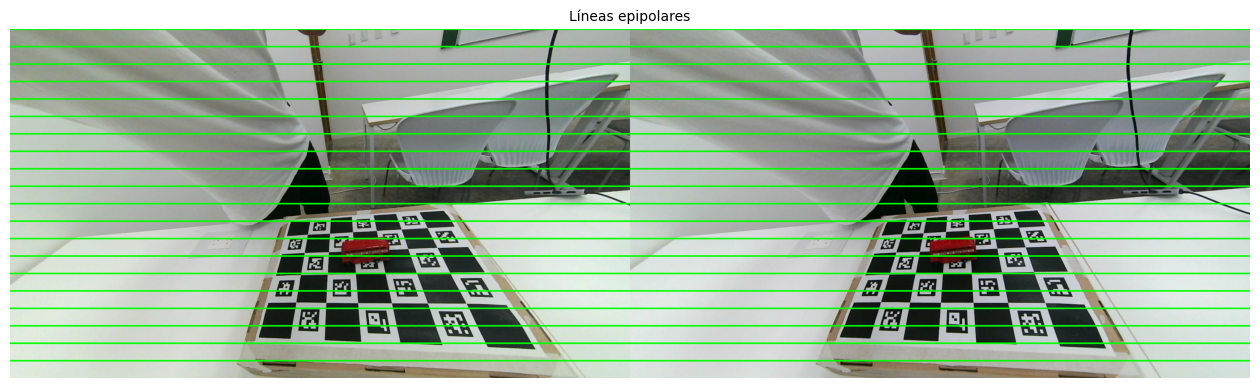

In [7]:
def draw_epipolar_lines(left_rect, right_rect, num_lines=20):
    """Dibuja líneas horizontales para verificar rectificación"""
    combined = np.hstack([left_rect, right_rect])
    h, w = left_rect.shape[:2]
    
    for y in range(0, h, h//num_lines):
        cv2.line(combined, (0, y), (2*w, y), (0, 255, 0), 3)
    
    return combined

combined = draw_epipolar_lines(rectL, rectR)
imshow(combined, title="Líneas epipolares", figsize=(16, 8))

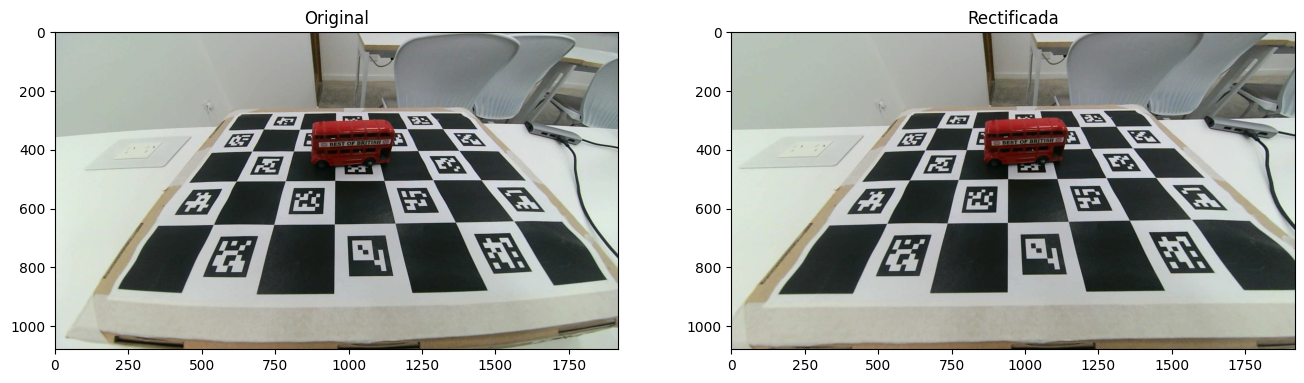

In [8]:
imgL = cv2.imread("data/stereo_bus_charuco/captures/left_14.jpg")

rectL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title("Rectificada")
plt.imshow(cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB))
plt.show()


In [9]:
from ipywidgets import interact, IntSlider, Checkbox

def show_pair_any(idx=14, rectificar=True, num_lines=20):
    left_path, right_path = f"data/stereo_bus_charuco/captures/left_{idx}.jpg", f"data/stereo_bus_charuco/captures/right_{idx}.jpg"

    if rectificar:
        L, R = rectify_stereo_pair(left_path, right_path, maps)
        titulo = "Rectificadas"
    else:
        L, R = cv2.imread(left_path), cv2.imread(right_path)
        titulo = "Originales (sin rectificar)"

    combined = draw_epipolar_lines(L, R, num_lines=num_lines)

    plt.figure(figsize=(18,9))
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.title(f"{titulo} - Par {idx}", fontsize=16)
    plt.axis("off")
    plt.show()

idx_slider   = IntSlider(min=14, max=37, step=1, value=14, layout={'width': '900px'})
lines_slider = IntSlider(min=5, max=50, step=5, value=20, layout={'width': '400px'})

interact(
    show_pair_any,
    idx=idx_slider,
    rectificar=Checkbox(value=True, description='Rectificar'),
    num_lines=lines_slider
)

interactive(children=(IntSlider(value=14, description='idx', layout=Layout(width='900px'), max=37, min=14), Ch…

<function __main__.show_pair_any(idx=14, rectificar=True, num_lines=20)>

## CÁLCULO DE DISPARIDAD

ETAPA 2: CÁLCULO DE DISPARIDAD

Parámetros SGBM:
  min_disp: 0
  num_disp: 160
  block_size: 7
  uniq: 12
  disp12: 1
  speckle_win: 150
  speckle_rng: 2
  prefilter_cap: 31
  mode: SGBM_3WAY

Procesando par #14...
  Cobertura: 43.7% (905380/2073600 píxeles)
  Rango disparidad: [0.6, 159.0]


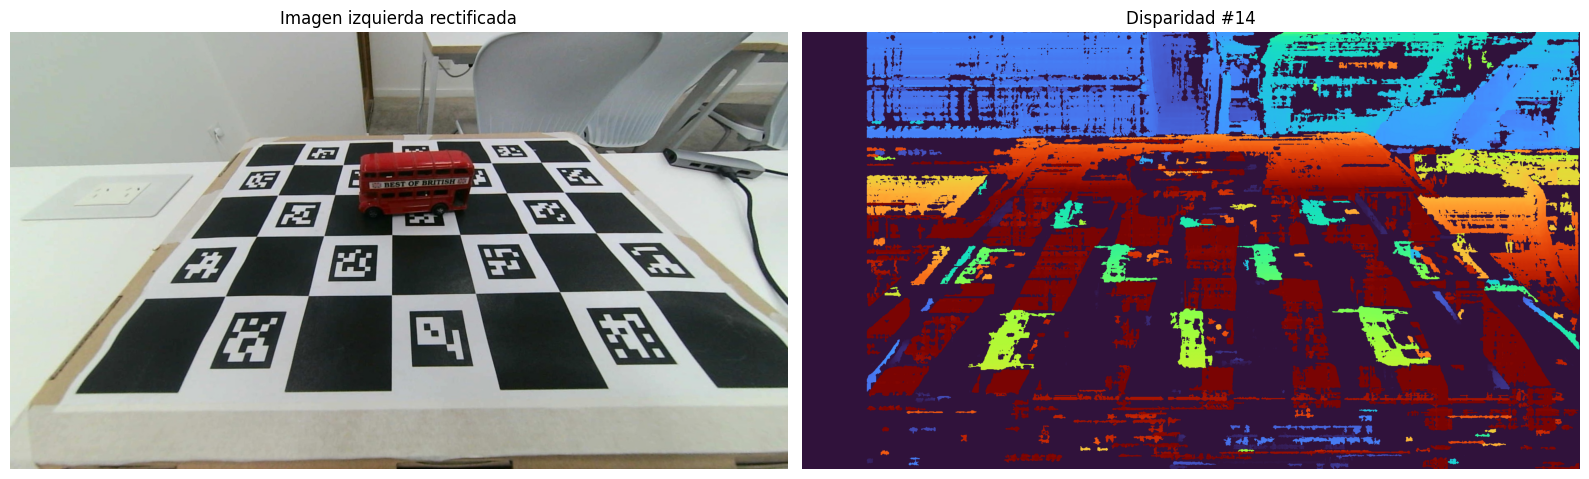

  ✓ Guardado en out\disparity

✓ ETAPA 2 COMPLETADA

Archivos generados:
  - out\disparity\disp_014.npy (datos crudos)
  - out\disparity\disp_014.png (visualización)
  - out\disparity\comparison_014.png (comparación)

Próximo paso: ETAPA 3 - Detección de patrón y pose


In [14]:
# === ETAPA 2: DISPARIDAD (versión mejorada y lista para usar) ===
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# ============== CONFIGURACIÓN ==============
RECT_DIR = Path("data/stereo_bus_charuco/rectified")
OUT_DIR = Path("out/disparity"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Parámetros SGBM optimizados (funcionan bien en la mayoría de casos)
SGBM_PARAMS = {
    "min_disp": 0,
    "num_disp": 160,        # suficiente para objetos a distancia media (múltiplo de 16)
    "block_size": 7,        # buen balance detalle/ruido (impar)
    "uniq": 12,             # UniquenessRatio (10-15 es bueno)
    "disp12": 1,            # Disp12MaxDiff
    "speckle_win": 150,     # SpeckleWindowSize (filtrar ruido)
    "speckle_rng": 2,       # SpeckleRange (1-2 recomendado)
    "prefilter_cap": 31,    # PreFilterCap
    "mode": "SGBM_3WAY"     # Mejor que SGBM normal
}

# ============== FUNCIONES REUTILIZABLES ==============

def load_rectified_pair(left_path, right_path):
    """Carga un par de imágenes rectificadas"""
    L = cv2.imread(str(left_path), cv2.IMREAD_COLOR)
    R = cv2.imread(str(right_path), cv2.IMREAD_COLOR)
    
    if L is None or R is None:
        raise FileNotFoundError(f"No pude cargar {left_path} o {right_path}")
    if L.shape != R.shape:
        raise ValueError(f"Dimensiones distintas: {L.shape} vs {R.shape}")
    
    return L, R


def compute_disparity_sgbm(L_bgr, R_bgr, params=None):
    """
    Calcula disparidad usando StereoSGBM con parámetros configurables.
    
    Args:
        L_bgr: Imagen izquierda (BGR)
        R_bgr: Imagen derecha (BGR)
        params: Dict con parámetros SGBM (usa SGBM_PARAMS por default)
    
    Returns:
        disparity: Mapa de disparidad en float32 (píxeles)
    """
    if params is None:
        params = SGBM_PARAMS
    
    # Convertir a escala de grises
    L_gray = cv2.cvtColor(L_bgr, cv2.COLOR_BGR2GRAY)
    R_gray = cv2.cvtColor(R_bgr, cv2.COLOR_BGR2GRAY)
    
    # Asegurar valores válidos
    num_disp = int(np.ceil(params["num_disp"] / 16) * 16)
    block_size = max(3, params["block_size"] | 1)  # forzar impar
    
    # Calcular P1 y P2 automáticamente si no están en params
    P1 = params.get("P1", 8 * 3 * block_size**2)
    P2 = params.get("P2", 32 * 3 * block_size**2)
    
    # Modo
    mode_str = params.get("mode", "SGBM_3WAY")
    if mode_str == "SGBM_3WAY":
        mode = cv2.STEREO_SGBM_MODE_SGBM_3WAY
    else:
        mode = cv2.STEREO_SGBM_MODE_SGBM
    
    # Crear matcher
    sgbm = cv2.StereoSGBM_create(
        minDisparity=params["min_disp"],
        numDisparities=num_disp,
        blockSize=block_size,
        P1=P1,
        P2=P2,
        disp12MaxDiff=params["disp12"],
        uniquenessRatio=params["uniq"],
        speckleWindowSize=params["speckle_win"],
        speckleRange=params["speckle_rng"],
        preFilterCap=params["prefilter_cap"],
        mode=mode
    )
    
    # Calcular disparidad
    disp = sgbm.compute(L_gray, R_gray).astype(np.float32) / 16.0
    
    return disp


def filter_disparity(disp, min_val=0.0, max_val=None):
    """
    Filtra valores inválidos del mapa de disparidad.
    
    Args:
        disp: Mapa de disparidad
        min_val: Valor mínimo válido
        max_val: Valor máximo válido (None = auto)
    
    Returns:
        disp_filtered: Disparidad filtrada (valores inválidos = 0)
    """
    if max_val is None:
        # Usar percentil 98 como máximo razonable
        valid = disp[disp > min_val]
        if valid.size > 0:
            max_val = np.percentile(valid, 98)
        else:
            max_val = min_val + 1.0
    
    # Crear máscara de valores válidos
    mask = (disp >= min_val) & (disp <= max_val)
    
    # Aplicar filtro
    disp_filtered = disp.copy()
    disp_filtered[~mask] = 0
    
    return disp_filtered


def colorize_disparity(disp, vmin=None, vmax=None):
    """
    Colorea el mapa de disparidad para visualización.
    
    Args:
        disp: Mapa de disparidad
        vmin: Valor mínimo (None = auto)
        vmax: Valor máximo (None = auto)
    
    Returns:
        disp_color: Imagen BGR coloreada
    """
    if vmin is None:
        vmin = 0.0
    
    if vmax is None:
        # Usar percentil 95 para mejor visualización
        valid = disp[disp > vmin]
        if valid.size > 0:
            vmax = np.percentile(valid, 95)
        else:
            vmax = vmin + 1.0
    
    # Normalizar y colorear
    disp_norm = np.clip(disp, vmin, vmax)
    disp_norm = (255 * (disp_norm - vmin) / (vmax - vmin + 1e-6)).astype(np.uint8)
    disp_color = cv2.applyColorMap(disp_norm, cv2.COLORMAP_TURBO)
    
    return disp_color


def visualize_disparity_result(left_img, disp, title="Disparidad"):
    """Visualiza imagen original y disparidad lado a lado"""
    disp_vis = colorize_disparity(disp)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].imshow(cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Imagen izquierda rectificada")
    axes[0].axis("off")
    
    axes[1].imshow(cv2.cvtColor(disp_vis, cv2.COLOR_BGR2RGB))
    axes[1].set_title(title)
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()


def process_single_pair(idx, rect_dir, output_dir, params=None, visualize=True):
    """
    Procesa un par estéreo completo: carga, disparidad, guarda.
    
    Args:
        idx: Índice del par
        rect_dir: Directorio con imágenes rectificadas
        output_dir: Directorio de salida
        params: Parámetros SGBM (None = usar defaults)
        visualize: Si True, muestra resultado
    
    Returns:
        disp: Mapa de disparidad calculado
    """
    # Rutas
    left_path = rect_dir / f"rect_left_{idx}.jpg"
    right_path = rect_dir / f"rect_right_{idx}.jpg"
    
    # Cargar
    print(f"Procesando par #{idx}...")
    L, R = load_rectified_pair(left_path, right_path)
    
    # Calcular disparidad
    disp = compute_disparity_sgbm(L, R, params)
    
    # Filtrar
    disp_filtered = filter_disparity(disp)
    
    # Estadísticas
    valid_pixels = np.sum(disp_filtered > 0)
    total_pixels = disp_filtered.size
    coverage = 100 * valid_pixels / total_pixels
    print(f"  Cobertura: {coverage:.1f}% ({valid_pixels}/{total_pixels} píxeles)")
    print(f"  Rango disparidad: [{disp_filtered[disp_filtered>0].min():.1f}, {disp_filtered.max():.1f}]")
    
    # Guardar
    output_dir.mkdir(parents=True, exist_ok=True)
    np.save(output_dir / f"disp_{idx:03d}.npy", disp_filtered)
    
    disp_vis = colorize_disparity(disp_filtered)
    cv2.imwrite(str(output_dir / f"disp_{idx:03d}.png"), disp_vis)
    
    # Comparación lado a lado
    side_by_side = np.hstack([L, disp_vis])
    cv2.imwrite(str(output_dir / f"comparison_{idx:03d}.png"), side_by_side)
    
    # Visualizar
    if visualize:
        visualize_disparity_result(L, disp_filtered, f"Disparidad #{idx}")
    
    print(f"  ✓ Guardado en {output_dir}")
    
    return disp_filtered


# ============== PROCESAR UN PAR DE EJEMPLO ==============

IDX = 14

print("="*60)
print("ETAPA 2: CÁLCULO DE DISPARIDAD")
print("="*60)
print()
print("Parámetros SGBM:")
for k, v in SGBM_PARAMS.items():
    print(f"  {k}: {v}")
print()

disp = process_single_pair(
    idx=IDX,
    rect_dir=RECT_DIR,
    output_dir=OUT_DIR,
    params=SGBM_PARAMS,
    visualize=True
)

print()
print("="*60)
print("✓ ETAPA 2 COMPLETADA")
print("="*60)
print()
print("Archivos generados:")
print(f"  - {OUT_DIR / f'disp_{IDX:03d}.npy'} (datos crudos)")
print(f"  - {OUT_DIR / f'disp_{IDX:03d}.png'} (visualización)")
print(f"  - {OUT_DIR / f'comparison_{IDX:03d}.png'} (comparación)")
print()
print("Próximo paso: ETAPA 3 - Detección de patrón y pose")

In [ ]:
"""# === CE: Optimización de parámetros con stereodemo (SGBM, VARIOS pares) ===
# Flujo:
# 1) Prepara una carpeta de sesión con N pares rectificados (no toca el dataset: usa symlinks/copia).
# 2) Abre stereodemo apuntando a esa carpeta (podés navegar con "Next Image").
# 3) Ajustás sliders, copiás valores al JSON y lo guardás (valores que funcionen bien en TODOS).
# 4) Cerrás la GUI y apretás ENTER acá; se cargan/validan los parámetros y quedan en SGBM_PARAMS.

import os, sys, json, shutil, subprocess, re
from pathlib import Path
import numpy as np

# -------- CONFIGURACIÓN (ajustá sólo esto) --------
RECT_DIR     = Path("data/stereo_bus_charuco/rectified")  # carpeta con tus JPG/PNG rectificados
IDX_LIST     = [14, 15, 22, 30, 36]  # índices a incluir (None = auto-seleccionar hasta 5 comunes)
MAX_AUTO_N   = 5                     # si IDX_LIST=None, cuántos pares tomar automáticamente
SESSION_ROOT = Path("out/stereodemo_session")
SESSION_DIR  = SESSION_ROOT / "multi"                      # carpeta de trabajo (se crea)
OUT_DIR      = Path("out/disparity_sgbm")                  # donde guardamos params finales

# -------- utilidades --------
def _parse_idx(p: Path) -> int:
    m = re.search(r"(\d+)", p.stem)
    return int(m.group(1)) if m else -1

def _list_common_indices(rect_dir: Path):
    lefts  = { _parse_idx(p): p for p in rect_dir.glob("rect_left_*.*")  if _parse_idx(p) >= 0 }
    rights = { _parse_idx(p): p for p in rect_dir.glob("rect_right_*.*") if _parse_idx(p) >= 0 }
    common = sorted(set(lefts) & set(rights))
    return common, lefts, rights

def _add_pair_to_session(src_left: Path, src_right: Path, dst_dir: Path, idx: int):
    """Crea enlaces simbólicos (o copia) con nombres que stereodemo detecta: left_XXX / right_XXX."""
    dst_dir.mkdir(parents=True, exist_ok=True)
    left_dst  = dst_dir / f"left_{idx:03d}{src_left.suffix}"
    right_dst = dst_dir / f"right_{idx:03d}{src_right.suffix}"
    # limpiar si existían
    for d in (left_dst, right_dst):
        if d.exists() or d.is_symlink():
            d.unlink()
    # preferir symlink para no duplicar datos
    try:
        os.symlink(src_left.resolve(), left_dst)
        os.symlink(src_right.resolve(), right_dst)
    except Exception:
        shutil.copy2(src_left, left_dst)
        shutil.copy2(src_right, right_dst)
    return left_dst, right_dst

def _sanitize_params(p: dict) -> dict:
    """Asegura múltiplos de 16, impar >=3, ints, etc."""
    q = p.copy()
    q["min_disp"]      = int(q.get("min_disp", 0))
    q["num_disp"]      = int(np.ceil(int(q.get("num_disp", 192)) / 16) * 16)
    q["block_size"]    = int(q.get("block_size", 7)) | 1
    q["uniq"]          = int(q.get("uniq", 12))
    q["disp12"]        = int(q.get("disp12", 1))
    q["speckle_win"]   = int(q.get("speckle_win", 150))
    q["speckle_rng"]   = int(q.get("speckle_rng", 2))
    q["prefilter_cap"] = int(q.get("prefilter_cap", 31))
    # post-proceso (opcionales para tu pipeline)
    q["median_ksize"]  = int(q.get("median_ksize", 0))
    q["bilateral_d"]   = int(q.get("bilateral_d", 0))
    q["bilateral_sigma_color"] = float(q.get("bilateral_sigma_color", 1.5))
    q["bilateral_sigma_space"] = float(q.get("bilateral_sigma_space", 1.5))
    # visualización
    vmax = q.get("vmax_fixed", None)
    q["vmax_fixed"] = float(vmax) if (vmax is not None and str(vmax).strip() != "None") else None
    # modo (opcional): "SGBM" o "SGBM_3WAY"
    if "mode" in q:
        q["mode"] = str(q["mode"]).upper().replace("MODE_", "")
        if q["mode"] not in ("SGBM", "SGBM_3WAY"):
            q["mode"] = "SGBM_3WAY"
    return q

# -------- descubrir índices y preparar sesión con VARIOS pares --------
common, lefts, rights = _list_common_indices(RECT_DIR)
if not common:
    raise SystemExit(f"No hay pares comunes rect_left_*.*/rect_right_*.* en {RECT_DIR.resolve()}")

if IDX_LIST is None:
    idxs = common[:MAX_AUTO_N]
else:
    # filtrar a los que realmente existen en ambos lados
    idxs = [i for i in IDX_LIST if (i in lefts and i in rights)]
    if not idxs:
        raise SystemExit("Ninguno de los índices solicitados existe en ambos lados. Revisá IDX_LIST.")

SESSION_DIR.mkdir(parents=True, exist_ok=True)
prepared = []
for i in idxs:
    Ldst, Rdst = _add_pair_to_session(lefts[i], rights[i], SESSION_DIR, i)
    prepared.append((i, Ldst, Rdst))

print("==============================================")
print(f"Sesión preparada con {len(prepared)} pares en:\n  {SESSION_DIR.resolve()}")
for i, Ld, Rd in prepared[:10]:
    print(f"  idx {i:03d}: {Ld.name} / {Rd.name}")
if len(prepared) > 10:
    print("  ...")

# -------- JSON de parámetros (plantilla) --------
OUT_DIR.mkdir(parents=True, exist_ok=True)
PARAMS_JSON = OUT_DIR / "stereodemo_params.json"
template = {
    "mode": "SGBM_3WAY",         # o "SGBM"
    "min_disp": 0,
    "num_disp": 192,             # múltiplo de 16
    "block_size": 7,             # impar
    "uniq": 12,                  # UniquenessRatio
    "disp12": 1,                 # Disp12MaxDiff
    "speckle_win": 150,          # SpeckleWindowSize
    "speckle_rng": 2,            # SpeckleRange (1–2 recomendado)
    "prefilter_cap": 31,         # PreFilterCap (SGBM)
    # P1/P2 opcionales (si los querés fijar): ej. para block=7 → P1=392, P2=1568
    # "P1": 392, "P2": 1568,
    # Post-proceso (opcionales para tu pipeline)
    "median_ksize": 0,           # 0=off, o 3/5
    "bilateral_d": 0,            # 0=off, o 3/5/7
    "bilateral_sigma_color": 1.5,
    "bilateral_sigma_space": 1.5,
    # Visualización
    "vmax_fixed": None           # None o por ej. 128 para comparar pares con misma escala
}
if not PARAMS_JSON.exists():
    with open(PARAMS_JSON, "w") as f:
        json.dump(template, f, indent=2)

print("\nSe abrirá stereodemo en esa carpeta. En la GUI:")
print("  • Navegá con 'Next Image' por los pares incluidos.")
print("  • Elegí 'OpenCV SGBM'.")
print("  • Ajustá sliders en este orden:")
print("    NumDisparities → BlockSize → Uniqueness → Disp12MaxDiff → SpeckleWindow/Range → (opcional) PreFilterCap")
print(f"  • Anotá y GUARDÁ los valores que funcionen bien en TODOS los pares en: {PARAMS_JSON.resolve()}")
print("Cerrá la GUI y volvé a esta celda. Cuando estés lista/o, apretá ENTER para continuar.\n")

# --- abrir stereodemo apuntando a la sesión multi ---
try:
    proc = subprocess.Popen(["stereodemo", str(SESSION_DIR.resolve())])
except FileNotFoundError:
    proc = subprocess.Popen([sys.executable, "-m", "stereodemo", str(SESSION_DIR.resolve())])

# (macOS) abrir el JSON en el editor por comodidad (opcional)
try:
    if sys.platform == "darwin":
        subprocess.Popen(["open", str(PARAMS_JSON.resolve())])
except Exception:
    pass

# -------- esperar confirmación y cargar parámetros --------
input(">>> ENTER cuando cierres stereodemo y hayas guardado el JSON ... ")

if not PARAMS_JSON.exists():
    raise SystemExit(f"No encuentro {PARAMS_JSON}. Guardá tus valores y reintentá.")

with open(PARAMS_JSON) as f:
    P = json.load(f)

SGBM_PARAMS = _sanitize_params(P)

# Guardamos una copia saneada para trazabilidad
with open(OUT_DIR / "stereodemo_params_sanitized.json", "w") as f:
    json.dump(SGBM_PARAMS, f, indent=2)

print("\nParámetros finales (saneados) cargados en SGBM_PARAMS:")
for k, v in SGBM_PARAMS.items():
    print(f"  {k}: {v}")

print(f"\nOK. Ahora corré tu celda de procesamiento (2.2/2.3/2.4) usando SGBM_PARAMS.")
"""

Sesión preparada con 5 pares en:
  C:\Users\Felipe\Documents\Vision_Artificial\TP2_Reconstruccion3D\tp2_reconstruccion_3d\out\stereodemo_session\multi
  idx 014: left_014.jpg / right_014.jpg
  idx 015: left_015.jpg / right_015.jpg
  idx 022: left_022.jpg / right_022.jpg
  idx 030: left_030.jpg / right_030.jpg
  idx 036: left_036.jpg / right_036.jpg

Se abrirá stereodemo en esa carpeta. En la GUI:
  • Navegá con 'Next Image' por los pares incluidos.
  • Elegí 'OpenCV SGBM'.
  • Ajustá sliders en este orden:
    NumDisparities → BlockSize → Uniqueness → Disp12MaxDiff → SpeckleWindow/Range → (opcional) PreFilterCap
  • Anotá y GUARDÁ los valores que funcionen bien en TODOS los pares en: C:\Users\Felipe\Documents\Vision_Artificial\TP2_Reconstruccion3D\tp2_reconstruccion_3d\out\disparity_sgbm\stereodemo_params.json
Cerrá la GUI y volvé a esta celda. Cuando estés lista/o, apretá ENTER para continuar.


Parámetros finales (saneados) cargados en SGBM_PARAMS:
  min_disp: 0
  num_disp: 192
  blo

ETAPA 3: DETECCIÓN DE CHARUCO Y CÁLCULO DE POSE

1. Cargando calibración...
   ✓ Calibración cargada

2. Creando ChArUco board...
   Dimensiones: 5x7
   Tamaño cuadrado: 52.6 mm
   Tamaño marker: 31.3 mm
   ✓ Board creado

3. Procesando par #14...

Detectando ChArUco en par #14...
  ✓ Detectadas 14 esquinas
  ✓ Pose calculada
     Rotación: [[-0.56579174  0.5740727   1.48135077]]
     Traslación: [[ 202.77074743 -131.84881519  291.62475656]] mm


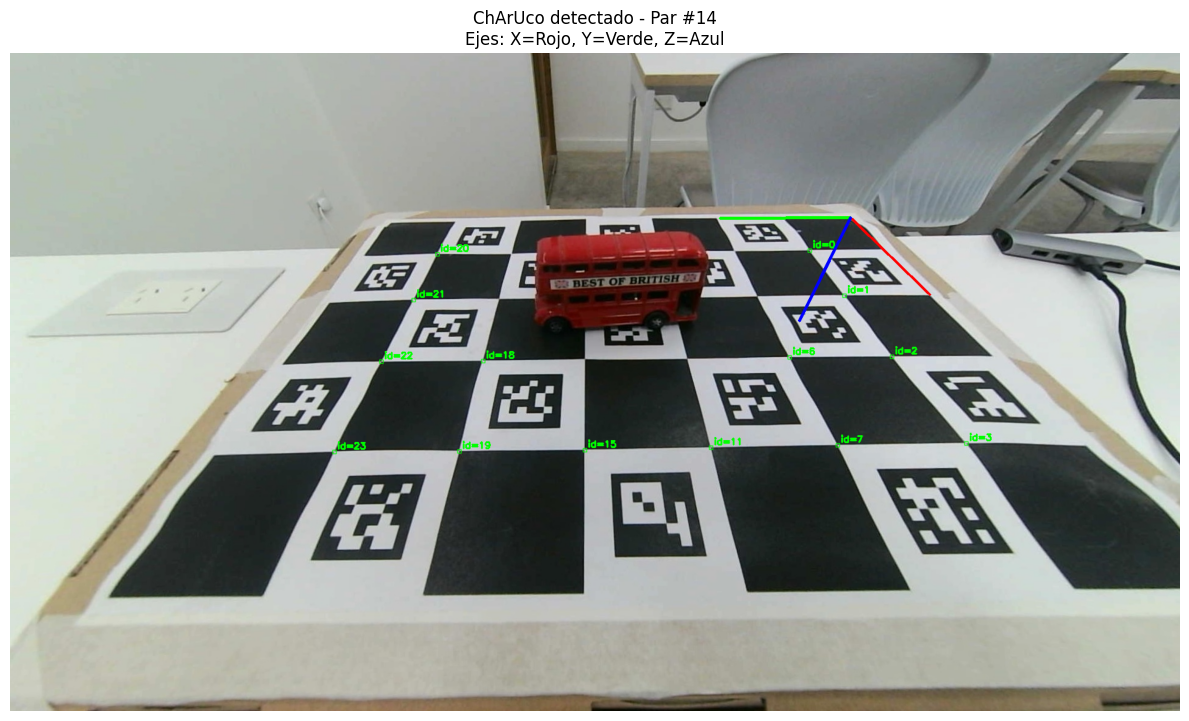


  ✓ Imagen guardada: out\pose\pose_014.png

Pose de cámara (par #14):
  Rotación:
    [ 0.01015812 -0.99990391  0.00943273]
    [0.74514058 0.01385996 0.66676339]
    [-6.66830062e-01  2.55648909e-04  7.45209771e-01]
  Traslación: [ 202.77074743 -131.84881519  291.62475656]
  Última fila: [0. 0. 0. 1.]

✓ ETAPA 3 COMPLETADA

Próximo paso: ETAPA 4 - Reproyección a 3D


In [19]:
# === ETAPA 3: DETECCIÓN DE CHARUCO Y CÁLCULO DE POSE ===
import cv2
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt

# ============== CONFIGURACIÓN ==============
RECT_DIR = Path("data/stereo_bus_charuco/rectified")
CALIB_PKL = Path("data/pkls/stereo_calibration.pkl")
OUT_DIR = Path("out/pose"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# Especificaciones del ChArUco board (de markers.yaml)
CHARUCO_CONFIG = {
    "squares_x": 5,          # Columnas de cuadrados
    "squares_y": 7,          # Filas de cuadrados
    "square_length": 52.6,   # Tamaño del cuadrado en mm
    "marker_length": 31.3,   # Tamaño del marker ArUco en mm
    "dictionary": cv2.aruco.DICT_6X6_250  # Diccionario ArUco
}

# ============== FUNCIONES ==============

def create_charuco_board(config):
    """
    Crea el objeto ChArUco board para detección.
    
    Args:
        config: Dict con especificaciones del board
    
    Returns:
        board: Objeto CharucoBoard de OpenCV
        dictionary: Diccionario ArUco
    """
    dictionary = cv2.aruco.getPredefinedDictionary(config["dictionary"])
    
    board = cv2.aruco.CharucoBoard(
        (config["squares_x"], config["squares_y"]),
        config["square_length"],
        config["marker_length"],
        dictionary
    )
    
    return board, dictionary


def get_charuco_3d_points(config):
    """
    Genera los puntos 3D de las esquinas del ChArUco en coordenadas del mundo.
    El origen (0,0,0) está en la esquina superior izquierda del board.
    
    Args:
        config: Dict con especificaciones del board
    
    Returns:
        object_points: Array de puntos 3D (N, 3)
    """
    # ChArUco tiene (squares_x - 1) * (squares_y - 1) esquinas internas
    nx = config["squares_x"] - 1
    ny = config["squares_y"] - 1
    square_size = config["square_length"]
    
    object_points = np.zeros((nx * ny, 3), dtype=np.float32)
    
    for i in range(ny):
        for j in range(nx):
            idx = i * nx + j
            object_points[idx] = [j * square_size, i * square_size, 0.0]
    
    return object_points


def detect_charuco(img, board, dictionary, K, dist):
    """
    Detecta ChArUco board en una imagen y calcula la pose.
    Compatible con OpenCV 4.7+
    
    Args:
        img: Imagen BGR
        board: Objeto CharucoBoard
        dictionary: Diccionario ArUco
        K: Matriz intrínseca de la cámara
        dist: Coeficientes de distorsión
    
    Returns:
        success: Bool indicando si se detectó el board
        corners: Esquinas detectadas (subpíxel)
        ids: IDs de las esquinas detectadas
        rvec: Vector de rotación (Rodrigues)
        tvec: Vector de traslación
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Parámetros de detección
    parameters = cv2.aruco.DetectorParameters()
    
    # Detectar markers ArUco
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    aruco_corners, aruco_ids, rejected = detector.detectMarkers(gray)
    
    if aruco_ids is None or len(aruco_ids) == 0:
        return False, None, None, None, None
    
    # Interpolar esquinas del ChArUco (API nueva de OpenCV 4.7+)
    charuco_detector = cv2.aruco.CharucoDetector(board)
    charuco_corners, charuco_ids, aruco_corners_used, aruco_ids_used = charuco_detector.detectBoard(gray)
    
    if charuco_corners is None or len(charuco_corners) < 4:
        return False, None, None, None, None
    
    # Estimar pose del board usando solvePnP directamente
    # Obtener puntos 3D correspondientes a las esquinas detectadas
    obj_points = board.getChessboardCorners()
    
    # Seleccionar solo los puntos correspondientes a los IDs detectados
    obj_points_detected = []
    for corner_id in charuco_ids:
        obj_points_detected.append(obj_points[corner_id[0]])
    obj_points_detected = np.array(obj_points_detected, dtype=np.float32)
    
    # Resolver PnP
    success, rvec, tvec = cv2.solvePnP(
        obj_points_detected,
        charuco_corners,
        K,
        dist,
        flags=cv2.SOLVEPNP_ITERATIVE
    )
    
    if not success:
        return False, charuco_corners, charuco_ids, None, None
    
    return True, charuco_corners, charuco_ids, rvec, tvec


def rodrigues_to_transform_matrix(rvec, tvec):
    """
    Convierte vectores de rotación (Rodrigues) y traslación a matriz 4x4.
    
    Args:
        rvec: Vector de rotación (3,1) o (3,)
        tvec: Vector de traslación (3,1) o (3,)
    
    Returns:
        T: Matriz de transformación homogénea 4x4
    """
    # Convertir rvec a matriz de rotación
    R, _ = cv2.Rodrigues(rvec)
    
    # Construir matriz homogénea
    T = np.eye(4, dtype=np.float64)
    T[:3, :3] = R
    T[:3, 3] = tvec.flatten()
    
    return T


def draw_charuco_detection(img, board, dictionary, corners, ids, rvec, tvec, K, dist):
    """
    Dibuja la detección del ChArUco y los ejes 3D sobre la imagen.
    
    Args:
        img: Imagen BGR
        board: Objeto CharucoBoard
        dictionary: Diccionario ArUco
        corners: Esquinas detectadas
        ids: IDs de las esquinas
        rvec: Vector de rotación
        tvec: Vector de traslación
        K: Matriz intrínseca
        dist: Coeficientes de distorsión
    
    Returns:
        img_out: Imagen con visualización
    """
    img_out = img.copy()
    
    # Dibujar esquinas y IDs del ChArUco
    if corners is not None and ids is not None:
        cv2.aruco.drawDetectedCornersCharuco(img_out, corners, ids, (0, 255, 0))
    
    # Dibujar ejes 3D (XYZ)
    if rvec is not None and tvec is not None:
        axis_length = CHARUCO_CONFIG["square_length"] * 2  # Longitud de los ejes
        cv2.drawFrameAxes(img_out, K, dist, rvec, tvec, axis_length, 3)
    
    return img_out


def process_pose_for_pair(idx, rect_dir, calib, board, dictionary, visualize=True):
    """
    Detecta ChArUco y calcula pose para un par estéreo.
    
    Args:
        idx: Índice del par
        rect_dir: Directorio con imágenes rectificadas
        calib: Dict con calibración
        board: Objeto CharucoBoard
        dictionary: Diccionario ArUco
        visualize: Si True, muestra resultado
    
    Returns:
        success: Bool indicando si se detectó y calculó pose
        T_cam_to_world: Matriz 4x4 de transformación
        img_with_axes: Imagen con ejes dibujados
    """
    # Cargar imagen izquierda rectificada
    left_path = rect_dir / f"rect_left_{idx}.jpg"
    
    if not left_path.exists():
        print(f"✗ No existe {left_path}")
        return False, None, None
    
    img = cv2.imread(str(left_path))
    
    # Extraer calibración de cámara izquierda
    K = calib['left_K']
    dist = calib['left_dist']
    
    # Detectar ChArUco y calcular pose
    print(f"Detectando ChArUco en par #{idx}...")
    success, corners, ids, rvec, tvec = detect_charuco(img, board, dictionary, K, dist)
    
    if not success:
        print(f"  ✗ No se pudo detectar ChArUco o calcular pose")
        return False, None, None
    
    num_corners = len(corners) if corners is not None else 0
    print(f"  ✓ Detectadas {num_corners} esquinas")
    print(f"  ✓ Pose calculada")
    print(f"     Rotación: {rvec.T}")
    print(f"     Traslación: {tvec.T} mm")
    
    # Convertir a matriz 4x4
    T_cam_to_world = rodrigues_to_transform_matrix(rvec, tvec)
    
    # Dibujar detección y ejes
    img_vis = draw_charuco_detection(img, board, dictionary, corners, ids, rvec, tvec, K, dist)
    
    # Visualizar
    if visualize:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.title(f"ChArUco detectado - Par #{idx}\nEjes: X=Rojo, Y=Verde, Z=Azul")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
    
    return True, T_cam_to_world, img_vis


def print_transform_matrix(T, title="Matriz de Transformación"):
    """Imprime matriz de transformación de forma legible"""
    print(f"\n{title}:")
    print("  Rotación:")
    for i in range(3):
        print(f"    {T[i, :3]}")
    print(f"  Traslación: {T[:3, 3]}")
    print(f"  Última fila: {T[3, :]}")


# ============== EJECUCIÓN ==============

# Cargar calibración
print("="*60)
print("ETAPA 3: DETECCIÓN DE CHARUCO Y CÁLCULO DE POSE")
print("="*60)
print()

print("1. Cargando calibración...")
with open(CALIB_PKL, 'rb') as f:
    calib = pickle.load(f)
print("   ✓ Calibración cargada")
print()

# Crear board ChArUco
print("2. Creando ChArUco board...")
print(f"   Dimensiones: {CHARUCO_CONFIG['squares_x']}x{CHARUCO_CONFIG['squares_y']}")
print(f"   Tamaño cuadrado: {CHARUCO_CONFIG['square_length']} mm")
print(f"   Tamaño marker: {CHARUCO_CONFIG['marker_length']} mm")
board, dictionary = create_charuco_board(CHARUCO_CONFIG)
print("   ✓ Board creado")
print()

# Procesar un par de ejemplo
IDX = 14

print(f"3. Procesando par #{IDX}...")
print()

success, T_cam_to_world, img_vis = process_pose_for_pair(
    idx=IDX,
    rect_dir=RECT_DIR,
    calib=calib,
    board=board,
    dictionary=dictionary,
    visualize=True
)

if success:
    # Guardar imagen con ejes
    output_path = OUT_DIR / f"pose_{IDX:03d}.png"
    cv2.imwrite(str(output_path), img_vis)
    print(f"\n  ✓ Imagen guardada: {output_path}")
    
    # Mostrar matriz de transformación
    print_transform_matrix(T_cam_to_world, f"Pose de cámara (par #{IDX})")
    
    print()
    print("="*60)
    print("✓ ETAPA 3 COMPLETADA")
    print("="*60)
    print()
    print("Próximo paso: ETAPA 4 - Reproyección a 3D")
else:
    print()
    print("="*60)
    print("✗ ERROR EN ETAPA 3")
    print("="*60)
    print()
    print("El ChArUco no se detectó correctamente.")
    print("Posibles causas:")
    print("  - Iluminación deficiente")
    print("  - Board parcialmente ocluido")
    print("  - Configuración incorrecta del board")
    print()
    print("Probá con otro índice de imagen.")

In [16]:
# Ver las claves del archivo de calibración
print("Claves en calib:", calib.keys())
print()
for key in calib.keys():
    print(f"{key}: {type(calib[key])}")

Claves en calib: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])

left_K: <class 'numpy.ndarray'>
left_dist: <class 'numpy.ndarray'>
right_K: <class 'numpy.ndarray'>
right_dist: <class 'numpy.ndarray'>
R: <class 'numpy.ndarray'>
T: <class 'numpy.ndarray'>
E: <class 'numpy.ndarray'>
F: <class 'numpy.ndarray'>
image_size: <class 'tuple'>


In [18]:
import cv2
print(cv2.__version__)

4.12.0


In [21]:
# === ETAPA 3 - VISUALIZACIONES EN OPEN3D ===
import open3d as o3d
import numpy as np
import cv2
from pathlib import Path

# Nota: Asumiendo que ya ejecutaste la celda anterior y tenés:
# - T_cam_to_world (matriz 4x4 de la pose)
# - calib (diccionario con calibración)
# - CHARUCO_CONFIG (especificaciones del board)

# ============== FUNCIONES DE VISUALIZACIÓN ==============

def create_world_coordinate_frame(size=100.0):
    """
    Crea los ejes del sistema de coordenadas del mundo (origen en ChArUco).
    
    Args:
        size: Longitud de los ejes en mm
    
    Returns:
        mesh: TriangleMesh de Open3D con los ejes
    """
    world_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=size,
        origin=[0, 0, 0]
    )
    return world_frame


def create_camera_frustum(T_cam_to_world, K, image_size, scale=50.0, color=[1, 0, 0]):
    """
    Crea una visualización de la cámara (frustum) en su pose.
    
    Args:
        T_cam_to_world: Matriz 4x4 de transformación
        K: Matriz intrínseca de la cámara
        image_size: Tupla (width, height)
        scale: Escala del frustum
        color: Color RGB normalizado [0-1]
    
    Returns:
        lineset: LineSet de Open3D representando la cámara
    """
    # Invertir transformación (de mundo a cámara para extrinsics)
    T_world_to_cam = np.linalg.inv(T_cam_to_world)
    
    # Crear intrinsics de Open3D
    width, height = image_size
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(
        width=width,
        height=height,
        fx=fx, fy=fy,
        cx=cx, cy=cy
    )
    
    # Crear frustum
    frustum = o3d.geometry.LineSet.create_camera_visualization(
        intrinsic=intrinsic,
        extrinsic=T_world_to_cam,
        scale=scale
    )
    
    # Colorear
    frustum.paint_uniform_color(color)
    
    return frustum


def create_charuco_board_mesh(config, thickness=1.0):
    """
    Crea una representación 3D del ChArUco board como referencia visual.
    
    Args:
        config: Dict con especificaciones del board
        thickness: Grosor del board en mm
    
    Returns:
        mesh: TriangleMesh representando el board
    """
    # Dimensiones del board
    width = config["squares_x"] * config["square_length"]
    height = config["squares_y"] * config["square_length"]
    
    # Crear caja rectangular
    board_mesh = o3d.geometry.TriangleMesh.create_box(
        width=width,
        height=height,
        depth=thickness
    )
    
    # Rotar para que esté en el plano XY (como el ChArUco real)
    # Por default la caja está en orientación diferente
    R = board_mesh.get_rotation_matrix_from_xyz((0, 0, 0))
    board_mesh.rotate(R, center=(0, 0, 0))
    
    # Trasladar para que esquina superior izquierda esté en origen
    board_mesh.translate([0, 0, -thickness])
    
    # Color gris claro
    board_mesh.paint_uniform_color([0.7, 0.7, 0.7])
    
    return board_mesh


def create_object_bounding_box(center, size, color=[0, 1, 0]):
    """
    Crea un bounding box orientado para enmarcar el objeto a reconstruir.
    
    Args:
        center: Centro del box [x, y, z] en mm
        size: Tamaño [width, height, depth] en mm
        color: Color RGB normalizado [0-1]
    
    Returns:
        bbox: OrientedBoundingBox de Open3D
    """
    # Crear bounding box
    bbox = o3d.geometry.OrientedBoundingBox(
        center=center,
        R=np.eye(3),  # Sin rotación
        extent=size
    )
    
    bbox.color = color
    
    return bbox


def estimate_object_bounding_box_from_image(config):
    """
    Estima un bounding box razonable para el objeto basándose en el ChArUco.
    Esto es una ESTIMACIÓN - ajustala según tu escena.
    
    Args:
        config: Dict con especificaciones del board
    
    Returns:
        center: Centro estimado [x, y, z]
        size: Tamaño estimado [width, height, depth]
    """
    # El bus está aproximadamente en el centro del board
    board_width = config["squares_x"] * config["square_length"]
    board_height = config["squares_y"] * config["square_length"]
    
    # Estimar centro del objeto (ajustar según tu escena)
    center_x = board_width / 2
    center_y = board_height / 2
    center_z = 50  # ~50mm por encima del board (ajustar)
    
    # Estimar tamaño del objeto (bus pequeño)
    size_x = 100  # ancho en mm
    size_y = 150  # largo en mm
    size_z = 80   # alto en mm
    
    center = np.array([center_x, center_y, center_z])
    size = np.array([size_x, size_y, size_z])
    
    return center, size


def visualize_scene_setup(T_cam_to_world, calib, charuco_config, 
                          show_board=True, show_bbox=True):
    """
    Visualiza la configuración completa de la escena en Open3D:
    - Ejes del mundo (origen en ChArUco)
    - Pose de la cámara
    - Board ChArUco (opcional)
    - Bounding box del objeto (opcional)
    
    Args:
        T_cam_to_world: Matriz 4x4 de transformación
        calib: Dict con calibración
        charuco_config: Dict con especificaciones del board
        show_board: Si True, muestra representación del board
        show_bbox: Si True, muestra bounding box estimado
    """
    geometries = []
    
    # 1. Ejes del mundo (origen en esquina del ChArUco)
    world_frame = create_world_coordinate_frame(size=100.0)
    geometries.append(world_frame)
    print("✓ Ejes del mundo agregados (X=Rojo, Y=Verde, Z=Azul)")
    
    # 2. Board ChArUco (referencia visual)
    if show_board:
        board_mesh = create_charuco_board_mesh(charuco_config, thickness=2.0)
        geometries.append(board_mesh)
        print("✓ Board ChArUco agregado (gris)")
    
    # 3. Frustum de la cámara
    K = calib['left_K']
    image_size = calib['image_size']
    camera_frustum = create_camera_frustum(
        T_cam_to_world, K, image_size, 
        scale=80.0,  # tamaño del frustum
        color=[1, 0, 0]  # rojo
    )
    geometries.append(camera_frustum)
    print("✓ Cámara agregada (frustum rojo)")
    
    # 4. Bounding box estimado para el objeto
    if show_bbox:
        center, size = estimate_object_bounding_box_from_image(charuco_config)
        bbox = create_object_bounding_box(center, size, color=[0, 1, 0])
        geometries.append(bbox)
        print("✓ Bounding box del objeto agregado (verde)")
        print(f"   Centro: {center}")
        print(f"   Tamaño: {size}")
        print("   NOTA: Este bbox es una ESTIMACIÓN. Ajustalo según tu escena.")
    
    # Visualizar todo
    print("\nAbriendo visualizador Open3D...")
    print("Controles:")
    print("  - Rotar: Click izquierdo + arrastrar")
    print("  - Pan: Ctrl + Click izquierdo + arrastrar")
    print("  - Zoom: Scroll")
    print("  - Reset view: R")
    
    o3d.visualization.draw_geometries(
        geometries,
        window_name="Configuración de la Escena - ETAPA 3",
        width=1200,
        height=800
    )


# ============== EJECUCIÓN ==============

print("="*60)
print("ETAPA 3 - VISUALIZACIONES EN OPEN3D")
print("="*60)
print()

# Verificar que tenemos los datos necesarios
if 'T_cam_to_world' not in locals():
    print("ERROR: Primero ejecutá la celda anterior de ETAPA 3")
    print("Necesitás tener T_cam_to_world, calib y CHARUCO_CONFIG")
else:
    print("Configuración de la escena:")
    print(f"  Par procesado: #{IDX}")
    print(f"  Board: {CHARUCO_CONFIG['squares_x']}x{CHARUCO_CONFIG['squares_y']}")
    print(f"  Imagen: {calib['image_size']}")
    print()
    
    # Visualizar todo junto
    visualize_scene_setup(
        T_cam_to_world=T_cam_to_world,
        calib=calib,
        charuco_config=CHARUCO_CONFIG,
        show_board=True,
        show_bbox=True
    )
    
    print()
    print("="*60)
    print("✓ VISUALIZACIONES COMPLETADAS")
    print("="*60)
    print()
    print("Podés ajustar el bounding box editando la función:")
    print("  estimate_object_bounding_box_from_image()")
    print()
    print("Próximo paso: ETAPA 4 - Reproyección 3D")

ModuleNotFoundError: No module named 'open3d'